**Imports**

In [24]:
#%pip install line_profiler
!pip install memory_profiler

#import line_profiler
%load_ext memory_profiler
#import wandb

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [63]:
import os
import sys
import glob
import time
import yaml as yl
import pickle as pk
import numpy as np
import pandas as pd
import subprocess
import datetime
import shutil
import tempfile
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report

from urllib.request import urlopen
from zipfile import ZipFile
from contextlib import contextmanager

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
plt.plot(np.array(history.history['loss']))
plt.title('model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Tensorflow**

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, Conv1D, MaxPool2D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import categorical_crossentropy

**Profiler**

**Functions**

In [10]:
def execute(cmdline):
    """Execute a command."""
    try:
        ret = subprocess.run(cmdline,
                        shell=True,
                        check=True,
                        capture_output=True)
    except subprocess.CalledProcessError:
        print('Execute: {}'.format(cmdline))
        return ''

    return ret.stdout.decode(), ret.stderr.decode()

def save(filename, data):
    """Save a file."""
    fout = open(filename, 'w')
    fout.write(data)
    fout.close()

def random_features(sequence):
    """Create random features."""
    new_sequence = np.random.random(sequence.shape)
    return new_sequence

def zero_to_random_features(sequence):
    """"Transform 0 in a random number."""
    new_sequence = np.copy(sequence)
    new_sequence[new_sequence == 0] = np.random.random()
    return new_sequence

def one_to_random_features(sequence):
    """"Transform 1 in a random number."""
    new_sequence = np.copy(sequence)
    new_sequence[new_sequence == 1] = np.random.random()
    return new_sequence

def create_model(labels, input_shape, model_type='v1'):
    model = Sequential()

    if model_type == 'v1_1d':
        model.add(Conv1D(filters=512, kernel_size=2, activation="relu", padding='same', input_shape=input_shape))
        model.add(Dense(units=512, activation="relu"))
        model.add(MaxPool1D())
        model.add(Flatten())
        model.add(Dense(labels, activation = 'sigmoid'))
    elif model_type == 'v2_1d':
        model.add(Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', input_shape=input_shape))
        model.add(MaxPool1D(pool_size=2))
        model.add(Conv1D(filters=32, kernel_size=5, activation="relu", padding='same'))
        model.add(MaxPool1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(units=128, activation="relu"))
        model.add(Dropout(rate=0.5))
        model.add(Dense(units=labels, activation = 'sigmoid'))
    elif model_type == 'v1_2d':
        model.add(Conv2D(filters=512, kernel_size=(2, 2), activation="relu", padding='same', input_shape=input_shape))
        model.add(Dense(units=512, activation="relu"))
        model.add(MaxPool2D())
        model.add(Flatten())
        model.add(Dense(labels, activation = 'sigmoid'))
    elif model_type == 'v2_2d':
        model.add(Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding='same', input_shape=input_shape))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Conv2D(filters=32, kernel_size=(5, 5), activation="relu", padding='same'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(units=128, activation="relu"))
        model.add(Dropout(rate=0.5))
        model.add(Dense(units=labels, activation = 'sigmoid'))
    return model

**Arguments**

In [39]:
# Google Driver
FLAGS_driver = '/home/nonroot/experiment/datasets/'
FLAGS_result = '/home/nonroot/experiment/results/'

# Train data ratio
FLAGS_train_ratio = 0.75

# Validation data ratio
FLAGS_val_ratio = 0.25

# Test data ratio
FLAGS_test_ratio = 0.20

# Number of epochs
FLAGS_epochs = 100

# Verbose
FLAGS_training_verbose = 1

# Store the results?
FLAGS_store_results = True

# Store the model?
FLAGS_store_model = False

# Store Wandb data?
FLAGS_store_wandb = False

# Wandb project name
FLAGS_project_name = 'bestseqssblp_200'

# Breakdown the runtime
FLAGS_times = {}

# Dataset
#
# classifyapp/Oz
# classifyapp/Oz
# bestseqssblp/O0/group1.1000
#
FLAGS_dataset = 'bestseqssblp2021.poj/200/Oz'

# Result directory
#
# classifyapp/POJ-104
FLAGS_r_d_name = 'bestseqssblp_200'

# Result directory suffix
FLAGS_suffix = ''

# Model
FLAGS_model = 'v2_1d'

# Source ratio (use all data?)
#
# It is not possible to use all POJ dataset in Colab (error -> out of memory).
# It is possible to load 450 sources (90%) per group.
#
# POJ ratios -> 0.9, 0.45, 0.09
FLAGS_source_ratio = 1.0

# Filter source data
FLAGS_filter_source = False

# Number of labels
#
# POJ labels -> 104, 52, 10
FLAGS_labels = 11

# Features type: random, zero to random, one to random
FLAGS_features = 'all_features'

# Round
FLAGS_round = 'round3'

# Random state
FLAGS_random_state = {'round1': 123456789, 'round2': 12345678, 'round3': 1234567}

# Sequence
#
# inst2vec.2d -> O0
# ir2vec.instructions (2d)
FLAGS_sequence = 'ir2vec.program'

# Results directory
last = '{}_{}_{}'.format(FLAGS_features, FLAGS_labels, FLAGS_source_ratio) if not FLAGS_suffix else '{}_{}_{}'.format(FLAGS_features, FLAGS_labels, FLAGS_source_ratio, FLAGS_suffix)
FLAGS_dataset_directory = os.path.join(FLAGS_driver, FLAGS_r_d_name, FLAGS_round, FLAGS_sequence, last)
# Dataset directory
FLAGS_results_directory = os.path.join(FLAGS_result, FLAGS_r_d_name, FLAGS_round, FLAGS_sequence, last)

**Import the dataset**

In [33]:
url = 'http://www.din.uem.br/~anderson/bestseqssblp_200-20210825T135354Z-001.zip'
fetch_and_extract_zip(url, extract_path=FLAGS_driver)

In [31]:
@contextmanager
def tmpdir(suffix=None, prefix='tmp', dir: str = None, remove: bool = True):
    dd = tempfile.mkdtemp(suffix=suffix, prefix=prefix, dir=dir)
    try:
        yield dd
    finally:
        if remove:
            shutil.rmtree(dd)
            
def fetch_and_extract_zip(zipurl, extract_path):
    with tmpdir() as d:
        tempfile = os.path.join(d, 'tempfile.zip')
        zipresp = urlopen(zipurl)
        tempzip = open(tempfile, "wb")
        tempzip.write(zipresp.read())
        tempzip.close()
        
        zf = ZipFile(tempfile)
        zf.extractall(path=extract_path)
        zf.close()

In [40]:
print(FLAGS_dataset_directory)

/home/nonroot/experiment/datasets/bestseqssblp_200/round3/ir2vec.program/all_features_11_1.0


**Load the dataset**

In [51]:
X = []
Y = [] 

start = time.time()

if FLAGS_filter_source:

    for label in range(1, FLAGS_labels+1):
        sources = graphs_size[label]
        sources.sort()

        nof_sources = int(len(sources) * FLAGS_source_ratio)  

    for i, source in enumerate(sources):
        try:
            filename = '{}/{}/{}.npz'.format(FLAGS_dataset_directory, label, source[1])
            sequence = np.load(filename)
        except:
            print('Erro load', FLAGS_dataset_directory, label, source[1], flush=True)
            continue
      
        sequence = sequence['values']
        if FLAGS_features == 'random_features':
            sequence = random_features(sequence)
        elif FLAGS_features == 'zero_to_random_features':
            sequence = zero_to_random_features(sequence)
        elif FLAGS_features == 'one_to_random_features':
            sequence = one_to_random_features(sequence) 

        Y.append(label-1)
        X.append(sequence)

        if i == nof_sources - 1:
            break

else:
    y_train = np.load(f'{FLAGS_dataset_directory}/y_train.npz')['values']
    y_test = np.load(f'{FLAGS_dataset_directory}/y_test.npz')['values']
    y_val = np.load(f'{FLAGS_dataset_directory}/y_val.npz')['values']

end = time.time()

FLAGS_times['loading'] = end - start

**Dataset statistics**

In [42]:
stat_labels = pd.Series(Y, name='label', dtype="category")
print('\n', stat_labels.value_counts().to_frame(), flush=True)


 Empty DataFrame
Columns: [label]
Index: []


**Prepare the dataaset**

In [ ]:
X = np.array(X)
Y = np.array(Y)

if '1d' in FLAGS_model:
  X = X.reshape(X.shape[0], X.shape[1], 1)
elif '2d' in FLAGS_model:
  rows = X[0].shape[0]
  cols = X[0].shape[1]
  X = X.reshape(X.shape[0], rows, cols, 1)
else:
  print('Error: model does not exist.')
  sys.exit(1)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,
                                                                    Y, 
                                                                    train_size=1.0-FLAGS_test_ratio,
                                                                    test_size=FLAGS_test_ratio,
                                                                    random_state=FLAGS_random_state[FLAGS_round])

X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X_train,
                                                                  Y_train,
                                                                  train_size=FLAGS_train_ratio,
                                                                  test_size=FLAGS_val_ratio,
                                                                  random_state=FLAGS_random_state[FLAGS_round])

print('Training:', X_train.shape[0], flush=True)
print('Validation:', X_val.shape[0], flush=True)
print('Test:', X_test.shape[0], flush=True)

Training: 1320
Validation: 440
Test: 440


**Create the model**

In [ ]:
input_shape = X[0].shape
print(input_shape)
model = create_model(FLAGS_labels, input_shape, FLAGS_model)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

(300, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 300, 16)           64        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 150, 16)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 150, 32)           2592      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 75, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2400)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               307328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)     

**Training**

In [ ]:
start = time.time()
%memit history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=50, epochs=FLAGS_epochs, verbose=FLAGS_training_verbose, shuffle=True)
end = time.time()

FLAGS_times['training'] = end - start

Epoch 1/100
27/27 [==============================] - 1s 15ms/step - loss: 2.4969 - accuracy: 0.1470 - val_loss: 2.1378 - val_accuracy: 0.3273
Epoch 2/100
27/27 [==============================] - 0s 6ms/step - loss: 2.1087 - accuracy: 0.2614 - val_loss: 1.9508 - val_accuracy: 0.2932
Epoch 3/100
27/27 [==============================] - 0s 6ms/step - loss: 2.0166 - accuracy: 0.3045 - val_loss: 1.8327 - val_accuracy: 0.4318
Epoch 4/100
27/27 [==============================] - 0s 6ms/step - loss: 1.8991 - accuracy: 0.3508 - val_loss: 1.7391 - val_accuracy: 0.4682
Epoch 5/100
27/27 [==============================] - 0s 8ms/step - loss: 1.8202 - accuracy: 0.3947 - val_loss: 1.6562 - val_accuracy: 0.4841
Epoch 6/100
27/27 [==============================] - 0s 6ms/step - loss: 1.7471 - accuracy: 0.4212 - val_loss: 1.5456 - val_accuracy: 0.6205
Epoch 7/100
27/27 [==============================] - 0s 6ms/step - loss: 1.6546 - accuracy: 0.4636 - val_loss: 1.4937 - val_accuracy: 0.5432
Epoch 8/100


**Testing**

In [ ]:
start = time.time()
%memit test_metrics = model.evaluate(X_test, Y_test)
end = time.time()

FLAGS_times['evaluating'] = end - start

test_metrics_dict = {}
for name, val in zip(model.metrics_names, test_metrics):
  print('{}: {:0.4f}'.format(name, val), flush=True)
  test_metrics_dict[name] = val

14/14 [==============================] - 0s 3ms/step - loss: 0.3887 - accuracy: 0.8818
peak memory: 2470.05 MiB, increment: 0.20 MiB
loss: 0.3887
accuracy: 0.8818


**Predicting**

In [ ]:
start = time.time()
%memit predicted = model.predict(X_test)
end = time.time()

FLAGS_times['predicting'] = end - start

peak memory: 2470.04 MiB, increment: 0.00 MiB


**Statistics**

In [ ]:
pred_y = predicted.argmax(axis=-1)

cm = confusion_matrix(Y_test, pred_y)
print('Confusion matrix')
print(cm)

cr = classification_report(Y_test, pred_y)
print('\n\nClassification report')
print(cr)

Confusion matrix
[[45  0  0  0  0  0  0  0  0  0  0]
 [ 0 22  0  0  1  0  8  0  0  0  1]
 [ 0  0 38  0  1  0  0  0  2  0  0]
 [ 0  0  0 43  0  0  0  0  0  0  0]
 [ 0  2  0  0 40  0  0  0  0  0  0]
 [ 0  1  0  0  0 33  0  0  0  0  0]
 [ 0 16  0  0  0  0 18  0  0  0  1]
 [ 0  0  0  0  0  0  0 42  0  0  0]
 [ 0  0  9  0  2  0  0  1 31  1  0]
 [ 0  0  2  0  1  0  0  0  2 39  0]
 [ 0  2  0  0  0  0  0  1  0  0 35]]


Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.51      0.69      0.59        32
           2       0.78      0.93      0.84        41
           3       1.00      1.00      1.00        43
           4       0.89      0.95      0.92        42
           5       1.00      0.97      0.99        34
           6       0.69      0.51      0.59        35
           7       0.95      1.00      0.98        42
           8       0.89      0.70      0.78        44
           9       0.

**Store the results**

In [ ]:
if FLAGS_store_results:
    os.makedirs(FLAGS_results_directory, exist_ok=True)   

    #
    # Store the results
    #

    # History
    fout = open('{}/history.yaml'.format(FLAGS_results_directory), 'w')
    yl.dump(history.history, fout)
    fout.close()

    # Test metrics
    fout = open('{}/test_metrics.yaml'.format(FLAGS_results_directory), 'w')
    yl.dump(test_metrics_dict, fout)
    fout.close()

    # Dataset
    np.savez_compressed('{}/y_train.npz'.format(FLAGS_results_directory), values=Y_train)
    np.savez_compressed('{}/y_val.npz'.format(FLAGS_results_directory), values=Y_val)
    np.savez_compressed('{}/y_test.npz'.format(FLAGS_results_directory), values=Y_test)

    # Predicted
    np.savez_compressed('{}/predicted'.format(FLAGS_results_directory), values=predicted)

    # Confusion matrix
    np.savez_compressed('{}/confusion_matrix'.format(FLAGS_results_directory), values=cm)

    # Classification report
    fout = open('{}/classification_report.pk'.format(FLAGS_results_directory), 'wb')
    pk.dump(cr, fout)
    fout.close()

    # Time
    fout = open('{}/elapsed_time.yaml'.format(FLAGS_results_directory), 'w')
    print(FLAGS_times)
    yl.dump(FLAGS_times, fout)
    fout.close()

    #
    # Store the hadware specifications
    #

    spec, _ = execute("nvidia-smi")
    filename = '{}/nvidia-smi.txt'.format(FLAGS_results_directory)
    save(filename, spec)

    spec, _ = execute("cat /proc/cpuinfo")
    filename = '{}/cpuinfo.txt'.format(FLAGS_results_directory)
    save(filename, spec)

    spec, _ = execute("cat /proc/meminfo")
    filename = '{}/meminfo.txt'.format(FLAGS_results_directory)
    save(filename, spec)  

  #
    # Store the model
    #
    if FLAGS_store_model:
        directory = '{}/model'.format(FLAGS_results_directory)
        os.makedirs(directory, exist_ok=True)
        model.save(directory)

{'loading': 1.6365668773651123, 'training': 18.246812105178833, 'evaluating': 0.7854611873626709, 'predicting': 0.5899162292480469}


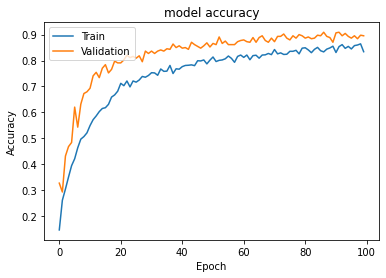

In [65]:
with open(os.path.join(FLAGS_dataset_directory, 'history.yaml')) as f:
    hist = yl.load(f, Loader=yl.FullLoader)
    plt.plot(np.array(hist['accuracy']))
    plt.plot(np.array(hist['val_accuracy']))
    plt.title('model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()